# Test 2

## Data Parallelism with Multi-devices

In [14]:
import mxnet as mx

In [15]:
def lenet():
    data = mx.sym.Variable('data')
    # first conv
    conv1 = mx.sym.Convolution(data = data, kernel = (5, 5), num_filter = 20)
    tanh1 = mx.sym.Activation(data = conv1, act_type = 'tanh')
    pool1 = mx.sym.Pooling(data = tanh1, pool_type = 'max', kernel = (2, 2), stride = (2, 2))
    # second conv
    conv2 = mx.sym.Convolution(data = pool1, kernel = (5, 5), num_filter = 50)
    tanh2 = mx.sym.Activation(data = conv2, act_type = 'tanh')
    pool2 = mx.sym.Pooling(data = tanh2, pool_type = 'max', kernel = (2, 2), stride = (2, 2))
    # first fullc
    flatten = mx.sym.Flatten(data = pool2)
    fc1 = mx.sym.FullyConnected(data = flatten, num_hidden = 500)
    tanh3 = mx.sym.Activation(data = fc1, act_type = 'tanh')
    # second fullc
    fc2 = mx.sym.FullyConnected(data = tanh3, num_hidden = 10)
    # loss
    lenet = mx.sym.SoftmaxOutput(data = fc2, name = 'out')
    return lenet

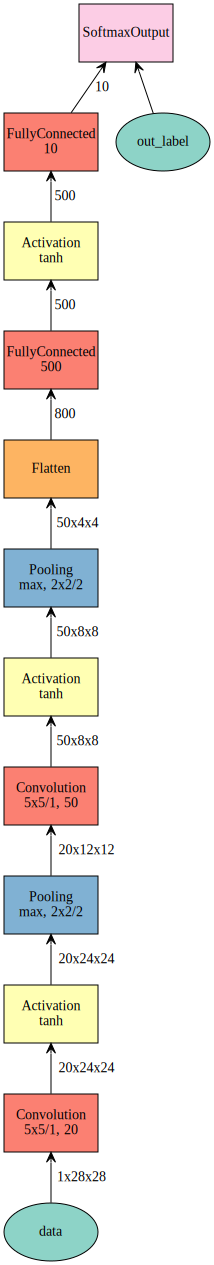

In [16]:
mx.viz.plot_network(lenet(), shape={'data':(128, 1, 28, 28)})

In [17]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class MNIST:
    def __init__(self):
        mnist = fetch_mldata('MNIST original', data_home='~/Datasets/')
        p = np.random.permutation(mnist.data.shape[0])
        self.X = mnist.data[p]
        self.Y = mnist.target[p]
        self.pos = 0        
    def get(self, batch_size):
        p = self.pos
        self.pos += batch_size
        return self.X[p:p+batch_size,:], self.Y[p:p+batch_size]
    def reset(self):
        self.pos = 0        
    def plot(self):
        for i in range(10):
            plt.subplot(1,10,i+1)
            plt.imshow(self.X[i].reshape((28,28)), cmap='Greys_r')
            plt.axis('off')
        plt.show()

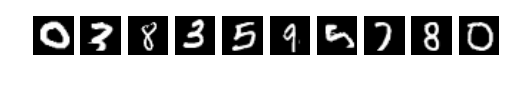

In [20]:
mnist = MNIST()
mnist.plot()

In [41]:
def train(network, data_shape, data, lr):
    # Get batch_size
    batch_size = float(data_shape[0])
    # Create an excutor
    ex = network.simple_bind(ctx=mx.gpu(), data=tuple(data_shape))
    # Initialize the args
    args = dict(zip(network.list_arguments(), ex.arg_arrays))
    for name in args:
        arr = args[name]
        if 'weight' in name:
            arr[:] = mx.random.uniform(-0.1, 0.1, arr.shape)
        if 'bias' in name:
            arr[:] = 0
    # Run 50 iterations
    learning_rate = lr
    acc = 0
    for i in range(50):
        # Get data
        tic = time.time()
        x, y = data()
        args['data'][:] = x.reshape(args['data'].shape)
        args['out_label'][:] = y.reshape(args['out_label'].shape)
        ex.forward(is_train=True)
        ex.backward()
        for weight, grad in zip(ex.arg_arrays, ex.grad_arrays):
            weight[:] -= learning_rate * (grad / batch_size)
        acc = (mx.nd.argmax_channel(ex.outputs[0]).asnumpy() == y).sum() / batch_size
        print("%d-th iteration, acc: %f time: %f sec" % (i+1, acc, (time.time()-tic)))
    return acc
        
        

In [13]:
import time

In [40]:
batch_size = 1024
shape = [batch_size, 1, 28, 28]
mnist.reset()
acc = train(lenet(), shape, lambda:mnist.get(batch_size), 0.1)

0-th iteration, acc: 0.084961 time: 0.123682 sec
1-th iteration, acc: 0.170898 time: 0.115883 sec
2-th iteration, acc: 0.233398 time: 0.109959 sec
3-th iteration, acc: 0.194336 time: 0.109084 sec
4-th iteration, acc: 0.305664 time: 0.108489 sec
5-th iteration, acc: 0.429688 time: 0.107881 sec
6-th iteration, acc: 0.489258 time: 0.108399 sec
7-th iteration, acc: 0.631836 time: 0.108018 sec
8-th iteration, acc: 0.680664 time: 0.108073 sec
9-th iteration, acc: 0.763672 time: 0.107970 sec
10-th iteration, acc: 0.687500 time: 0.108148 sec
11-th iteration, acc: 0.746094 time: 0.107671 sec
12-th iteration, acc: 0.795898 time: 0.108051 sec
13-th iteration, acc: 0.844727 time: 0.107956 sec
14-th iteration, acc: 0.837891 time: 0.108014 sec
15-th iteration, acc: 0.844727 time: 0.107825 sec
16-th iteration, acc: 0.856445 time: 0.108272 sec
17-th iteration, acc: 0.886719 time: 0.107804 sec
18-th iteration, acc: 0.885742 time: 0.108146 sec
19-th iteration, acc: 0.880859 time: 0.107790 sec
20-th iter